# **Análisis Exploratorio de Datos**

Las imágenes utilizadas en este estudio provienen de la iniciativa **Alzheimer’s Disease Neuroimaging Initiative (ADNI)**, un repositorio internacional de neuroimágenes longitudinales. Se seleccionaron exclusivamente imágenes estructurales T1‐ponderadas (MRI) correspondientes a sujetos con diagnóstico deterioro cognitivo leve (MCI) y demencia tipo Alzheimer (AD).

El dataset tabular proviene de los datos clínicos y neuropsicológicos asociados a las mismas visitas de imagen, conteniendo información sociodemográfica, genética, diagnóstica y volumétrica (FreeSurfer).

In [1]:
# [Config] Librerías
import pandas as pd
import os
import nibabel as nib
import re
import numpy as np
import pandas as pd
from datetime import datetime
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## DATOS TABULARES

In [2]:
# [Config] Rutas
df_tab = pd.read_csv("../Data/TABULAR.csv")
df_dx = pd.read_csv('../Data/ANDI_out.csv')

In [3]:
# Caracteristicas
print("CARACTERÍSTICAS\n")
print("======================"
      f"\n💿 Imágenes: {len(df_tab)}"
      f"\n👨‍🦳 Cantidad de pacientes: {df_dx['sujeto_id'].nunique()}"
      f"\n⏺️ Vistas dispobibles: {df_dx['Visit'].nunique()}, en los meses {df_tab['Visita'].unique()}"
      "\n======================"
)

# Progeso de la enfermedad
labels_por_sujeto = df_tab.groupby("sujeto_id")["label"].first()
tabla_1 = pd.DataFrame({
    "conteo": labels_por_sujeto.value_counts(),
    "porcentaje": labels_por_sujeto.value_counts(normalize=True).mul(100).round(2)
})
tabla_1.index = tabla_1.index.map({0: "No progreso", 1: "Progreso"})
display(tabla_1.style.set_caption("Distribución del progreso de la enfermedad"))

# Imágnes
tabla_2 = pd.DataFrame({
    "conteo": df_tab["is_dementia"].value_counts(),
    "porcentaje": df_tab["is_dementia"].value_counts(normalize=True).mul(100).round(2)
})
tabla_2.index = tabla_2.index.map({0: "MCI", 1: "Dementia"})
display(tabla_2.style.set_caption("Distribución de imágenes con Dementia"))

# Edad
print("======================"
      f"\n#️⃣ Edad de los pacientes:"
      f"\nMín: {df_tab['Age'].min()} | Máx: {df_tab['Age'].max()} | Mean: {df_tab['Age'].mean().round(2)}"
      "\n======================"
)

# Sexo
sex = df_tab.groupby("sujeto_id")["Sexo"].first()
tabla_3 = pd.DataFrame({
    "conteo": sex.value_counts(),
    "porcentaje": sex.value_counts(normalize=True).mul(100).round(2)
})
tabla_3.index = tabla_3.index.map({0: "Masculino", 1: "Femenino"})
display(tabla_3.style.set_caption("Distribución del sexo"))

# Nivel educativo
educat = {
    10: "10 años (básica incompleta)",
    12: "12 años (secundaria completa)",
    13: "13 años (secundaria + 1 año)",
    14: "14 años (preuniversitario)",
    16: "16 años (licenciatura)",
    17: "17 años (posgrado parcial)",
    18: "18 años (maestría)",
    19: "19 años (posgrado incompleto)",
    20: "20 años (doctorado/profesional)"
}
tabla_4 = pd.DataFrame({
    "conteo": df_tab["Educat"].value_counts(),
    "porcentaje": df_tab["Educat"].value_counts(normalize=True).mul(100).round(2)
})
tabla_4.index = tabla_4.index.map(educat)
display(tabla_4.style.set_caption("Distribución de nivel educativo"))

CARACTERÍSTICAS

💿 Imágenes: 220
👨‍🦳 Cantidad de pacientes: 51
⏺️ Vistas dispobibles: 7, en los meses [ 6 12 18 24 36 48 60]


,conteo,porcentaje
label,,
No progreso,31,60.780000
Progreso,20,39.220000


,conteo,porcentaje
is_dementia,,
MCI,158,71.820000
Dementia,62,28.180000


#️⃣ Edad de los pacientes:
Mín: 61 | Máx: 91 | Mean: 75.79


,conteo,porcentaje
Sexo,,
Masculino,38,74.510000
Femenino,13,25.490000


,conteo,porcentaje
Educat,,
16 años (licenciatura),62,28.180000
18 años (maestría),53,24.090000
20 años (doctorado/profesional),31,14.090000
19 años (posgrado incompleto),19,8.640000
12 años (secundaria completa),17,7.730000
14 años (preuniversitario),14,6.360000
10 años (básica incompleta),13,5.910000
17 años (posgrado parcial),6,2.730000
13 años (secundaria + 1 año),5,2.270000


Variables Volumétricas

* APOE4 es una variante genética de la apolipoproteína E 
    "CDRSB", #"Suma de cajas del Clinical Dementia Rating (CDR); mide la severidad de la demencia.",/
    "MMSE", #"Mini-Mental State Examination; evaluación global del estado cognitivo (máx. 30 puntos).",/
    "ADAS13", #"Alzheimer’s Disease Assessment Scale – 13 ítems; mide deterioro cognitivo en Alzheimer.",
    "FAQ", #"Functional Activities Questionnaire; evalúa la capacidad funcional en actividades diarias.",
    "RAVLT_immediate", # "Puntuación inmediata en la prueba verbal de aprendizaje (Rey Auditory Verbal Learning Test).",
    "RAVLT_learning", # "Puntuación de aprendizaje acumulado en RAVLT; mide retención verbal.",
    "RAVLT_forgetting", # "Índice de olvido en RAVLT; diferencia entre aprendizaje y recuerdo tardío.",
    "DIGITSCOR", #"Digit Span Score; mide memoria de trabajo y atención mediante secuencias numéricas.",
    "TRABSCOR", # "Trail Making Test B Score; evalúa función ejecutiva y flexibilidad cognitiva.",
]
volumen = [
    "Ventricles", # "Volumen de los ventrículos cerebrales; puede indicar atrofia cerebral.",
    "Hippocampus", # "Volumen del hipocampo; clave en memoria y afectado en Alzheimer.",
    "WholeBrain", # "Volumen total del cerebro; útil para evaluar atrofia global.",
    "Entorhinal", # "Volumen de la corteza entorrinal; región afectada tempranamente en Alzheimer.",
    "Fusiform", #"Volumen del giro fusiforme; relacionado con reconocimiento visual.",
    "MidTemp", # "Volumen del lóbulo temporal medio; implicado en memoria y procesamiento auditivo.",
    "ICV", #"Volumen intracraneal total; usado para normalizar medidas volumétricas."
]

In [37]:
df['EXAMDATE'] = pd.to_datetime(df['EXAMDATE'], errors='coerce')

mapa_viscode = {'bl':0, "m06": 6,"m12": 12,"m18": 18,"m24": 24, 'm30': 30, "m36": 36}
df["VISCODE"] = df["VISCODE"].map(mapa_viscode)

def categorizar_educacion(anios):
    if anios <= 10:
        return "Primaria o menos"
    elif anios <= 12:
        return "Secundaria completa"
    elif anios <= 14:
        return "Técnico o incompleto universitario"
    elif anios <= 16:
        return "Universitario completo"
    elif anios <= 18:
        return "Posgrado corto"
    else:
        return "Posgrado avanzado"
df["PTEDUCAT"] = df["PTEDUCAT"].apply(categorizar_educacion)

## **1. Descripción del conjunto de datos**

In [38]:
# []
print("-" * 30)
print("📁 Información general:")
print(f"\nDimensión: {df.shape[0]} Imágenes disponibles × {df.shape[1]} atributos")
print(f"\nTipo de atributos: \n{df.dtypes.value_counts()}")
print("-" * 30)
print(f"👦 {df['sujeto_id'].nunique()} sujetos en estudio")

------------------------------
📁 Información general:

Dimensión: 279 Imágenes disponibles × 35 atributos

Tipo de atributos: 
float64           22
object            11
int64              1
datetime64[ns]     1
Name: count, dtype: int64
------------------------------
👦 51 sujetos en estudio


El conjunto de datos esta compuesto por 279 imágenes asociadas a 51 sujetos, donde se dispone de multiples imágenes por paciente. En total, se registran 34 atributos por imagen. 

In [39]:
print("-" * 30)
print("📁 Valores nulos:")
print(f"Variables con valores nulos:")
nulos = df.isna().sum()
porcentaje = (nulos / len(df)) * 100
tabla_nulos = pd.DataFrame({
    "Variable": nulos.index,
    "Cantidad_nulos": nulos.values,
    "Porcentaje_nulos": porcentaje.round(2)
})
tabla_nulos = tabla_nulos[tabla_nulos["Cantidad_nulos"] > 0]
tabla_nulos = tabla_nulos.sort_values(by="Cantidad_nulos", ascending=False).reset_index(drop=True)
tabla_nulos

------------------------------
📁 Valores nulos:
Variables con valores nulos:


,Variable,Cantidad_nulos,Porcentaje_nulos
0,Hippocampus,67,24.01
1,MidTemp,67,24.01
2,Fusiform,67,24.01
3,Entorhinal,67,24.01
4,ICV,38,13.62
5,WholeBrain,38,13.62
6,Ventricles,38,13.62
7,FAQ,31,11.11
8,TRABSCOR,31,11.11
9,RAVLT_forgetting,30,10.75


In [40]:
# DX con valores nulos
print("-" * 30)
print("📁 DX con valores nulos:")
print(f"Registros con DX nulos: {df['DX'].isna().sum()}")
porcentaje_nulo = df["DX"].isna().mean() * 100
print(f"{porcentaje_nulo:.2f}% de los registros no tienen DX asignado.")
df_dx_nulo = df[df["DX"].isna()]
print(f"Diagnosticos nulos en las vistas: {df_dx_nulo['VISCODE'].unique()}")
print("-" * 30)
print(df_dx_nulo[["sujeto_id", "VISCODE", "EXAMDATE", "DX"]])



------------------------------
📁 DX con valores nulos:
Registros con DX nulos: 28
10.04% de los registros no tienen DX asignado.
Diagnosticos nulos en las vistas: [30]
------------------------------
      sujeto_id  VISCODE   EXAMDATE   DX
5    007_S_0101       30 2008-07-18  NaN
12   007_S_0128       30 2008-08-20  NaN
18   007_S_0249       30 2008-10-01  NaN
29   014_S_0169       30 2008-09-16  NaN
48   018_S_0142       30 2008-08-20  NaN
54   018_S_0155       30 2008-10-06  NaN
60   021_S_0141       30 2008-09-09  NaN
72   021_S_0273       30 2008-10-13  NaN
78   021_S_0276       30 2008-10-01  NaN
84   022_S_0004       30 2008-05-08  NaN
90   023_S_0042       30 2008-06-24  NaN
97   023_S_0126       30 2008-10-23  NaN
104  027_S_0116       30 2008-08-18  NaN
115  027_S_0256       30 2008-10-16  NaN
122  027_S_0307       30 2008-10-30  NaN
134  032_S_0214       30 2008-10-16  NaN
147  035_S_0204       30 2008-09-26  NaN
157  037_S_0150       30 2008-09-10  NaN
178  067_S_0176       

Se identifican 28 registros **(10.04%)** sin diagnóstico asignado *(DX = NaN)*, todos correspondientes a la visita de seguimiento de los 30 meses *(VISCODE = 30)*. Esto revela un patrón sistemático de ausencia de datos, más que una pérdida aleatoria. Este patrón sugiere que la ausencia del diagnóstico no está relacionada con un error de captura, sino con la estructura temporal del estudio, donde algunas sesiones pueden incluir únicamente medidas de imagen o datos intermedios sin clasificación clínica.



## **2. Propiedades técnicas de las imágenes**

In [41]:
# [] Formato de imagen - Orientación - Tipo de dato y unidades
shape_counts = df["shape"].value_counts() #Formatos de imagen
orint_counts = df["orientation"].value_counts() #Orientación espacial

tabla_shape= pd.DataFrame({
    "Shape": shape_counts.index,
    "Imágenes": shape_counts.values
})

tabla_orientarion= pd.DataFrame({
    "Orientación": orint_counts.index,
    "Imágenes": orint_counts.values
})

print("\nFormatos de imagen:")
print(tabla_shape)

print("\nOrientación:")
print(tabla_orientarion)

print(f"\nTipos de datos {df['datatype'].unique()} \nUnidades {df['units'].unique()}") #Tipo de dato y unidades



Formatos de imagen:
             Shape  Imágenes
0  (160, 192, 192)        99
1  (166, 256, 256)        89
2  (180, 256, 256)        35
3  (256, 256, 170)        34
4  (256, 256, 184)         9
5  (170, 256, 256)         6
6  (160, 240, 256)         4
7  (176, 256, 256)         1
8  (170, 288, 288)         1
9  (162, 256, 256)         1

Orientación:
       Orientación  Imágenes
0  ('R', 'A', 'S')       236
1  ('P', 'S', 'R')        43

Tipos de datos ['int16'] 
Unidades ["('mm', 'sec')"]


El conjunto de imágenes presenta una diversidad moderada en sus dimensiones espaciales, con un total de 10 configuraciones distintas de tamaño (shape).
El formato más común es (160, 192, 192), correspondiente a 99 imágenes, seguido por (166, 256, 256) con 89 imágenes, lo que indica que existe una variabilidad entre protocolos o escáneres de adquisición. Esta heterogeneidad en las dimensiones (ejes de voxeles) sugiere que las imágenes provienen de diferentes estudios o centros clínicos, posiblemente con distintos parámetros de adquisición. Por tanto, antes de realizar cualquier modelado, será necesario homogeneizar las dimensiones mediante re-escalado o re-muestreo volumétrico para garantizar la comparabilidad entre sujetos.

En cuanto a la orientación espacial, la mayoría de las imágenes (236 de 279) están alineadas bajo el sistema estándar ('R', 'A', 'S'), que indica los ejes Right–Anterior–Superior, mientras que un grupo menor (43 imágenes) sigue la orientación ('P', 'S', 'R'). Esta diferencia puede generar inconsistencias visuales al entrenar los modelos utilizando a los distintos sujetos, por lo que se tendria que reorientar todas las imagenes a un marco anatómico común. 

> **¿Como interpretar los marcos de Orientación Espacial?**
> - 'R', 'L': Right / Left (derecha / izquierda).
> - 'A', 'P': Anterior / Posterior (frontal / trasera).
> - 'S', 'I': Superior / Inferior (arriba / abajo).
> 
>**Por ejemplo:**
> - ('R', 'A', 'S'): Ejes orientados hacia la derecha, adelante y arriba.
> - ('P', 'S', 'R'): Ejes hacia atrás, arriba y derecha — diferente orden y dirección.

In [42]:
# Resoluciones de voxel
voxel_counts = df["voxel_size"].value_counts()
volumen_counts = df["voxel_volume_mm3"].value_counts()
total_counts = df["total_volume"].value_counts()

tabla_voxel= pd.DataFrame({
    "Voxel": voxel_counts.index,
    "Imágenes": voxel_counts.values
})
tabla_volum= pd.DataFrame({
    "Volumen": volumen_counts.index,
    "Imágenes": volumen_counts.values
})
tabla_total= pd.DataFrame({
    "Volumen total": total_counts.index,
    "Imágenes": total_counts.values
})

print("\nResoluciones de voxel:")
print(tabla_voxel)
print("\nVolumen de voxel:")
print(tabla_volum)
print("\nVolumen estimado:")
print(tabla_total)


Resoluciones de voxel:
                          Voxel  Imágenes
0         (1.2, 0.9375, 0.9375)       113
1             (1.2, 1.25, 1.25)        97
2         (0.9375, 0.9375, 1.2)        41
3   (1.1998978, 0.9375, 0.9375)         6
4               (1.2, 1.0, 1.0)         4
5   (1.1996994, 0.9375, 0.9375)         3
6   (1.1996002, 0.9375, 0.9375)         3
7         (1.2, 0.9766, 0.9766)         1
8   (1.2, 0.8680556, 0.8680556)         1
9   (0.9765625, 0.9765625, 1.2)         1
10        (1.1999999, 1.0, 1.0)         1
11              (1.0, 1.0, 1.2)         1
12    (1.2, 0.976562, 0.976562)         1
13  (1.1996994, 0.9766, 0.9766)         1
14  (1.2001953, 0.9375, 0.9375)         1
15  (1.2003021, 0.9375, 0.9375)         1
16  (1.2, 1.2760416, 1.2760416)         1
17  (1.2, 1.3020834, 1.3020834)         1
18   (1.199884, 0.9375, 0.9375)         1

Volumen de voxel:
     Volumen  Imágenes
0   1.054688       154
1   1.875000        97
2   1.054598         6
3   1.200000         5
4 

Las imágenes presentan variabilidad en la resolución de voxel, con dos configuraciones predominantes: (1.2, 0.9375, 0.9375) y (1.2, 1.25, 1.25), que abarcan más del 75% del total.
Esta diferencia refleja el uso de distintos protocolos o escáneres, lo que hace necesario re-escalar y normalizar las imágenes antes del análisis.
Los volúmenes cerebrales estimados (~1.1×10⁷–1.3×10⁷ mm³) son coherentes con medidas anatómicas normales, confirmando una buena calidad de la base de datos.

In [43]:
# Intensidad de imagen
print("Intensidad de la imagen")
print("-" * 30)
# Brillo
resumen_mean = df['mean_intensity'].describe().round(2).to_frame(name='mean_intensity')
resumen_mean.index.name = 'Brillo'
print(resumen_mean)
print("-" * 30)
# Contraste
resumen_std = df['std_intensity'].describe().round(2).to_frame(name='std_intensity')
resumen_std.index.name = 'Contraste'
print(resumen_std)

Intensidad de la imagen
------------------------------
        mean_intensity
Brillo                
count           279.00
mean          32013.94
std           71216.46
min              11.66
25%             101.73
50%             127.50
75%             274.09
max          363261.17
------------------------------
           std_intensity
Contraste               
count             279.00
mean            47971.67
std            107668.61
min                16.62
25%               132.22
50%               168.22
75%               369.50
max            579786.68


El brillo promedio (media de intensidades) es de **≈ 32013** unidades, con una desviación estándar muy alta **(71216)**, y un rango que va desde *11.66* hasta *363261.* Esta dispersión indica que las imágenes no se encuentran normalizadas en escala de intensidad, lo cual podría deberse a la combinación de datos provenientes de diferentes escáneres o secuencias de **MRI** **(T1 vs T2)**. La presencia de valores máximos extremadamente altos sugiere que algunas imágenes podrían estar en diferentes unidades o escalas de cuantificación.

En cuanto al contraste (desviación estándar de intensidades), se observa un valor medio de **≈ 47971**, con una desviación estándar también elevada (**107668**).
Este comportamiento refuerza la idea de heterogeneidad radiométrica, donde algunas imágenes presentan distribuciones de intensidad muy planas (bajo contraste), mientras que otras muestran mayor separación entre tejidos.

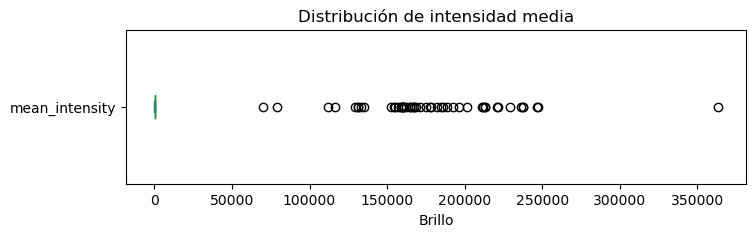

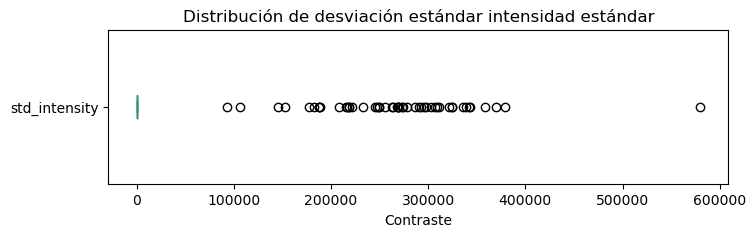

In [44]:
plt.figure(figsize=(8, 2))
df['mean_intensity'].plot.box(vert=False)
plt.title("Distribución de intensidad media")
plt.xlabel("Brillo")

plt.figure(figsize=(8, 2))
df['std_intensity'].plot.box(vert=False)
plt.title("Distribución de desviación estándar intensidad estándar")
plt.xlabel("Contraste")
plt.show()

In [45]:
# Configuración mayoritaria de las imágenes
variables = {
    "shape": df["shape"],
    "orientation": df["orientation"],
    "voxel_size": df["voxel_size"],
    "voxel_volume_mm3": df["voxel_volume_mm3"],
    "total_volume": df["total_volume"]
}

# Construir tabla resumen
resumen = []

for nombre, serie in variables.items():
    valor_frecuente = serie.value_counts().idxmax()
    cantidad_frecuente = serie.value_counts().max()
    cantidad_diferente = (serie != valor_frecuente).sum()
    
    resumen.append({
        "Variable": nombre,
        "Más frecuente": valor_frecuente,
        "Cantidad": cantidad_frecuente,
        "Diferentes": cantidad_diferente
    })

tabla_resumen = pd.DataFrame(resumen)
print(tabla_resumen)

           Variable          Más frecuente  Cantidad  Diferentes
0             shape        (160, 192, 192)        99         180
1       orientation        ('R', 'A', 'S')       236          43
2        voxel_size  (1.2, 0.9375, 0.9375)       113         166
3  voxel_volume_mm3               1.054688       154         125
4      total_volume             11059200.0        97         182


Al observar la configuración de las imágenes, se aprecia que el conjunto de datos no es completamente uniforme, aunque sí existen algunos patrones claros.

La mayoría de las imágenes comparten una forma de 160 × 192 × 192 voxeles, lo que indica que varias provienen de un mismo protocolo o tipo de escáner. En cuanto a la orientación, la más común es **('R', 'A', 'S')**, es decir, *Right–Anterior–Superior*. Esto quiere decir que la mayoría de las imágenes están alineadas en el mismo sentido anatómico, lo cual es positivo, ya que facilita la comparación y el análisis conjunto de los volúmenes. 

También se observa que muchos estudios comparten una resolución de voxel de **(1.2, 0.9375, 0.9375)** mm, con un volumen de aproximadamente 1.05 mm³, lo que refleja una buena calidad espacial de las imágenes. Aun así, la presencia de muchas combinaciones diferentes de resolución y tamaño de voxel indica que será necesario unificar las características espaciales antes de realizar análisis más avanzados o entrenar modelos.


In [46]:
# Imágenes con brillo y contraste outliers
def detectar_outliers_iqr(serie, nombre_columna):
    """
    Devuelve un DataFrame con los valores outliers de una columna numérica según el método IQR.
    """
    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    outliers = (serie < limite_inferior) | (serie > limite_superior)
    print(f"🔹{nombre_columna}: {outliers.sum()} outliers detectados")
    return outliers

df["outlier_mean_intensity"] = detectar_outliers_iqr(df["mean_intensity"], "mean_intensity")
df["outlier_std_intensity"] = detectar_outliers_iqr(df["std_intensity"], "std_intensity")

# Etiqueta combinada de calidad
df["calidad_intensidad"] = "ok"
df.loc[df["outlier_mean_intensity"], "calidad_intensidad"] = "outlier_media"
df.loc[df["outlier_std_intensity"], "calidad_intensidad"] = "outlier_contraste"
df.loc[df["outlier_mean_intensity"] & df["outlier_std_intensity"], "calidad_intensidad"] = "outlier_ambos"



🔹mean_intensity: 50 outliers detectados
🔹std_intensity: 50 outliers detectados


In [47]:
# Puntaje de calidad 

shape_fr = df["shape"].value_counts().idxmax()
orien_fr = df["orientation"].value_counts().idxmax()
voxel_fr = df["voxel_size"].value_counts().idxmax()
volum_fr = df["voxel_volume_mm3"].value_counts().idxmax()
total_fr = df["total_volume"].value_counts().idxmax()

# Criterios de calidad
df["fail_shape"] = df["shape"] != shape_fr
df["fail_orientation"] = df["orientation"] != orien_fr
df["fail_voxel_size"] = df["voxel_size"] != voxel_fr
df["fail_voxel_volume"] = df["voxel_volume_mm3"] != volum_fr
df["fail_total_volume"] = df["total_volume"] != total_fr

# Outliers de intensidad
def detectar_outliers_iqr(serie):
    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)
    IQR = Q3 - Q1
    return (serie < Q1 - 1.5 * IQR) | (serie > Q3 + 1.5 * IQR)

df["fail_mean_intensity"] = detectar_outliers_iqr(df["mean_intensity"])
df["fail_std_intensity"] = detectar_outliers_iqr(df["std_intensity"])

# Puntaje total de fallos por imagen
df["puntaje_calidad"] = (
    df["fail_shape"].astype(int) +
    df["fail_orientation"].astype(int) +
    df["fail_voxel_size"].astype(int) +
    df["fail_voxel_volume"].astype(int) +
    df["fail_total_volume"].astype(int) +
    df["fail_mean_intensity"].astype(int) +
    df["fail_std_intensity"].astype(int)
)
resumen_puntajes = df["puntaje_calidad"].value_counts().sort_index()
print(" Distribución de puntajes de calidad:")
resumen_puntajes= pd.DataFrame({
    "Puntaje": resumen_puntajes.index,
    "Imágenes": resumen_puntajes.values
})
print(resumen_puntajes)

 Distribución de puntajes de calidad:
   Puntaje  Imágenes
0        2       205
1        3         2
2        4        27
3        6        43
4        7         2


El puntaje de calidad asignado a cada imagen indica el nivel de degradación o corrupción presente en ella, donde valores más bajos reflejan mayor calidad visual y, por tanto, menor distorsión.

La gran mayoría de las imágenes (205) tienen un puntaje de 2, lo que indica una alta calidad general del conjunto y poca presencia de artefactos o errores de procesamiento. Solo 2 imágenes presentan un puntaje de 3, y 27 imágenes alcanzan un puntaje de 4, lo que sugiere ligeras degradaciones sin impacto significativo. En contraste, 43 imágenes presentan un puntaje de 6, y 2 imágenes alcanzan 7, reflejando un nivel de corrupción elevado, posiblemente debido a ruido, pérdida de resolución o errores de adquisición.

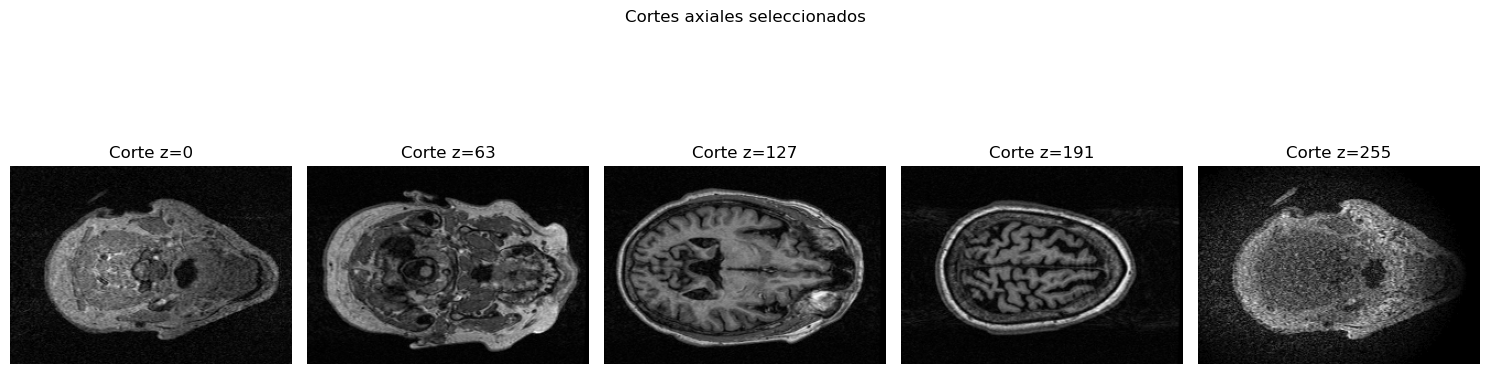

In [48]:

# Cargar imagen
img = nib.load(r"C:\Users\Hp\MACHINE\MRI\Datos\IMAGES\021_S_0273\MP-RAGE\2006-03-14_10_55_38.0\I11942\ADNI_11M4_BC_4.nii")
data = img.get_fdata()

# Seleccionar 5 cortes equiespaciados en el eje axial (z)
num_cortes = 5
indices = np.linspace(0, data.shape[2] - 1, num_cortes, dtype=int)

# Mostrar los cortes
plt.figure(figsize=(15, 5))
for i, idx in enumerate(indices):
    plt.subplot(1, num_cortes, i + 1)
    plt.imshow(data[:, :, idx], cmap="gray")
    plt.title(f"Corte z={idx}")
    plt.axis("off")

plt.suptitle("Cortes axiales seleccionados")
plt.tight_layout()
plt.show()


## **3. Sobre el paciente**

In [49]:
# Crear DataFrame resumen por sujeto
info_sujetos = df.groupby('sujeto_id').agg({
    'AGE': 'mean',         # Edad
    'PTGENDER': 'first',   # género
    'PTEDUCAT': 'first',   # educación
    'DX': 'last',
    'APOE4': 'first',
}).reset_index()

------------------------------
Edades de los pacientes
count    51.000000
mean     74.525490
std       6.904574
min      60.300000
25%      70.200000
50%      75.200000
75%      79.500000
max      88.300000
Name: AGE, dtype: float64


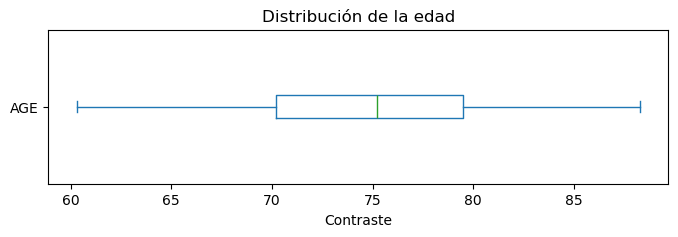

In [50]:
# EDADES
print("-"*30)
print("Edades de los pacientes")
print(info_sujetos['AGE'].describe())
plt.figure(figsize=(8, 2))
info_sujetos['AGE'].plot.box(vert=False)
plt.title("Distribución de la edad")
plt.xlabel("Contraste")
plt.show()

El conjunto de datos incluye información de los 51 pacientes, con una edad promedio de aproximadamente 75 años. Las edades oscilan entre los 60 y 88 años, teniendo en cuenta que la población corresponde principalmente a adultos mayores.

La distribución es relativamente concentrada, con la mitad de los pacientes entre 70 y 80 años, y una desviación estándar de 6.9 años, lo que sugiere una variabilidad moderada en la edad.


------------------------------
Sexo de los pacientes
          count
PTGENDER       
Male         38
Female       13


<Axes: ylabel='PTGENDER'>

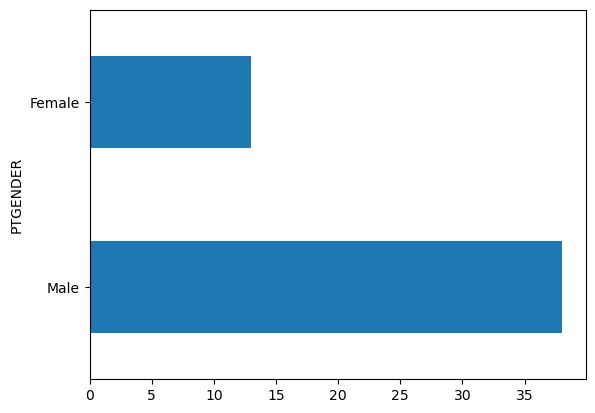

In [51]:
# SEXO
print("-"*30)
print("Sexo de los pacientes")
print(info_sujetos['PTGENDER'].value_counts().to_frame())
info_sujetos['PTGENDER'].value_counts().plot.barh()

------------------------------
Nivel educativo de los pacientes
                                    count
PTEDUCAT                                 
Universitario completo                 16
Posgrado corto                         12
Posgrado avanzado                      11
Técnico o incompleto universitario      5
Secundaria completa                     4
Primaria o menos                        3


<Axes: ylabel='PTEDUCAT'>

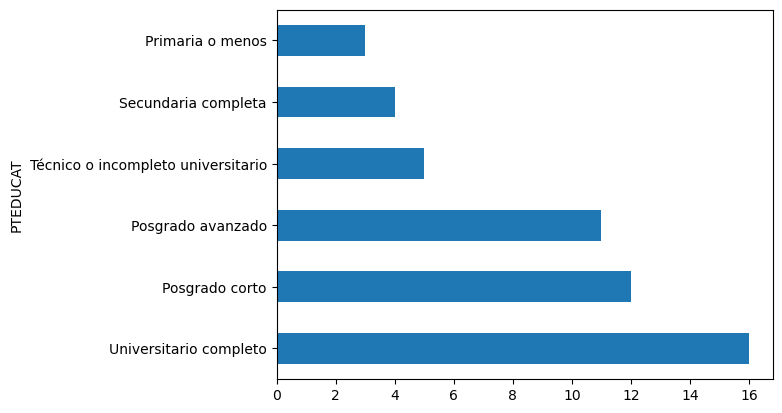

In [52]:
# Educación
print("-"*30)
print("Nivel educativo de los pacientes")
print(info_sujetos['PTEDUCAT'].value_counts().to_frame())
info_sujetos['PTEDUCAT'].value_counts().plot.barh()

La mayoría de los pacientes del estudio presentan un alto nivel educativo. Cerca del **77%** cuenta con formación universitaria o de posgrado, lo que sugiere una muestra predominantemente conformada por personas con acceso a educación superior.

En detalle, 16 pacientes **(≈32%)** completaron estudios universitarios, **12 (≈25%)** alcanzaron un posgrado corto, y **11 (≈21%)** un posgrado avanzado. Los niveles educativos más bajos, como secundaria o primaria, están presentes en pocos casos (menos del **15%** en conjunto).

------------------------------
Genotipo APOE4
       count
APOE4       
0.0       23
1.0       22
2.0        6


<Axes: ylabel='APOE4'>

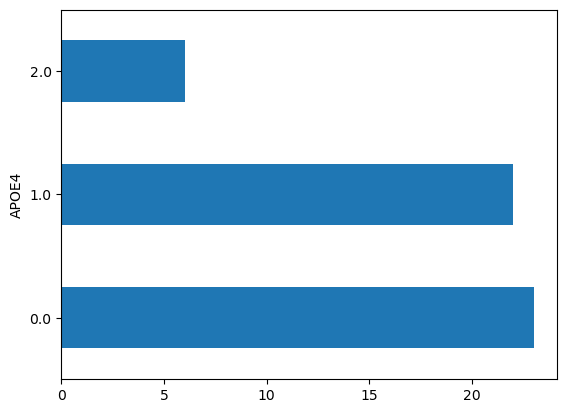

In [53]:
# APOE4
print("-"*30)
print("Genotipo APOE4")
print(info_sujetos['APOE4'].value_counts().to_frame())
info_sujetos['APOE4'].value_counts().plot.barh()

El análisis del genotipo **APOE4**, un marcador genético estrechamente relacionado con la susceptibilidad al Alzheimer, revela una distribución equilibrada dentro del grupo de pacientes. Cerca de la mitad de ellos no presenta el alelo **(23 individuos)**, mientras que una proporción similar posee una sola copia **(22 individuos)**, y un grupo más reducido, compuesto por seis pacientes, cuenta con dos copias del alelo **APOE4**. Esta variabilidad genética es relevante, ya que la presencia de una o dos copias de **APOE4** se ha asociado con un mayor riesgo de desarrollar Alzheimer y con un posible inicio más temprano de los síntomas.

------------------------------
Genotipo DX
          count
DX             
MCI          29
Dementia     22


<Axes: ylabel='DX'>

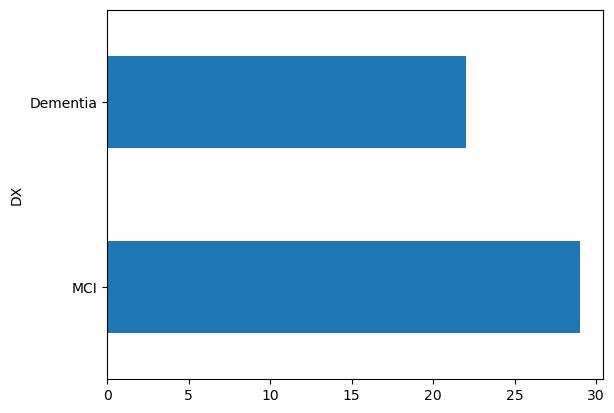

In [54]:
# Diagnóstico final
print("-"*30)
print("Genotipo DX")
print(info_sujetos['DX'].value_counts().to_frame())
info_sujetos['DX'].value_counts().plot.barh()

El conjunto de pacientes presenta una distribución moderadamente equilibrada entre los distintos estados clínicos del diagnóstico (**DX**). La mayoría corresponde a casos de deterioro cognitivo leve (**MCI**), con **29 pacientes**, mientras que los **22 restantes** han sido diagnosticados con demencia, fase más avanzada del Alzheimer. Esta composición refleja una muestra representativa de distintas etapas del deterioro cognitivo, lo que permite analizar tanto los cambios estructurales tempranos como los asociados a un daño cerebral más severo.

                count
duracion_anios       
1                  12
2                  22
3                  16
4                   1


<Axes: ylabel='duracion_anios'>

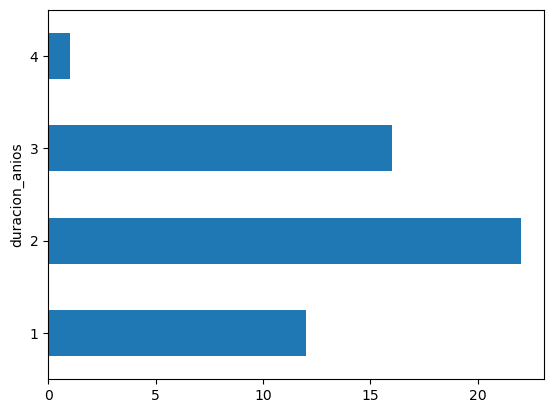

In [55]:
df["EXAMDATE"] = pd.to_datetime(df["EXAMDATE"])
df["año"] = df["EXAMDATE"].dt.year
df_duracion = df.sort_values(["sujeto_id", "EXAMDATE"]).groupby("sujeto_id").agg(
    año_inicio=("año", "first"),
    año_final=("año", "last")
).reset_index()

df_duracion["duracion_anios"] = df_duracion["año_final"] - df_duracion["año_inicio"]
print(df_duracion["duracion_anios"].value_counts().sort_index().to_frame())

df_duracion["duracion_anios"].value_counts().sort_index().plot.barh()

La duración del seguimiento clínico de los pacientes varía entre cero y cuatro años, concentrándose principalmente en períodos intermedios. La mayoría de los sujetos fueron observados durante **dos años** **(22 pacientes)** o **tres años (16 pacientes)**, mientras que un grupo menor tuvo un seguimiento de **un año (12 pacientes)**. Solo uno alcanzó los **cuatro años de registro**.

## **4. Progresión clínica**

   Vistas  Pacientes
0       3          6
1       4          7
2       5         10
3       6         13
4       7         15
Resumen de número de visitas por paciente:


Text(0, 0.5, 'Frecuencia')

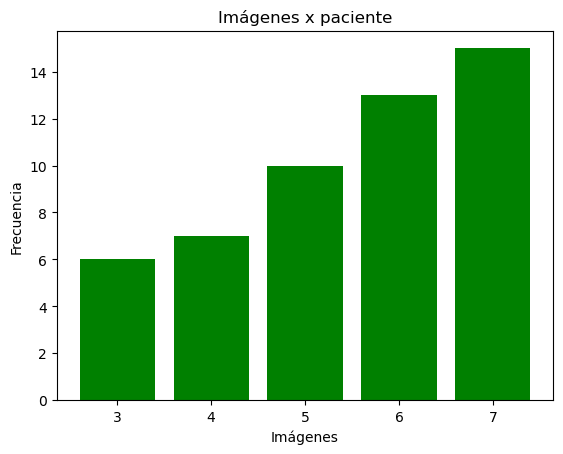

In [56]:
# Vistas por pacientes
tabla_visitas = (
    df
    .assign(valor="O")  # marcamos presencia
    .pivot_table(index="sujeto_id", columns="VISCODE", values="valor", aggfunc="first", fill_value="X")
    .sort_index(axis=1)
)
tabla_visitas
conteo_visitas = (tabla_visitas == "O").sum(axis=1)
resumen_visitas = conteo_visitas.value_counts().sort_index()
tabla_resumen = pd.DataFrame({
    "Vistas": resumen_visitas.index,
    "Pacientes": resumen_visitas.values
})
print(tabla_resumen)
print("Resumen de número de visitas por paciente:")
plt.bar(tabla_resumen["Vistas"], tabla_resumen["Pacientes"], color='green')
plt.title("Imágenes x paciente")
plt.xlabel("Imágenes")
plt.ylabel("Frecuencia")

El número de visitas por paciente muestra una distribución progresiva, donde la mayoría de los individuos cuentan con un seguimiento prolongado a lo largo de varias evaluaciones clínicas o sesiones de imagen. En total, **15 pacientes realizaron 7 visitas**, constituyendo el grupo más numeroso y representando un **seguimiento continuo y completo** dentro del estudio. A continuación, le siguen los grupos con **6 visitas (13 pacientes)** y **5 visitas (10 pacientes)**, lo que refleja una buena retención de participantes. En contraste, solo un número reducido de pacientes tuvo **3 o 4 visitas (6 y 7 casos, respectivamente)**, posiblemente debido a abandonos o inclusión tardía en el estudio.


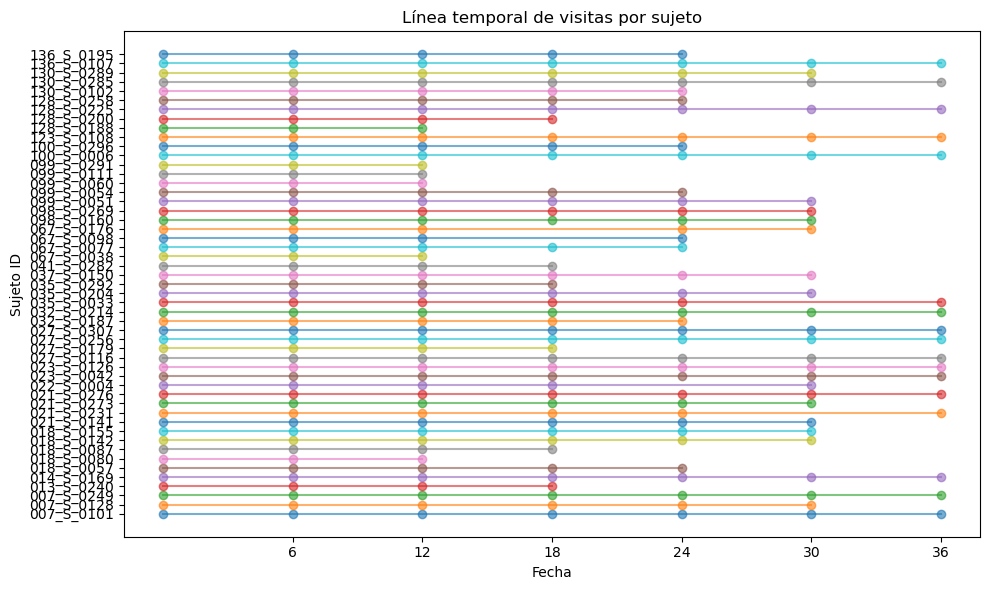

In [57]:
# Linea de vistas por sujeto
plt.figure(figsize=(10,6))
for sid, grupo in df.groupby('sujeto_id'):
    plt.plot(grupo['VISCODE'], [sid]*len(grupo), marker='o', linestyle='-', alpha=0.6)
plt.title('Línea temporal de visitas por sujeto')
plt.xticks(ticks=range(6, 37, 6))
plt.xlabel('Fecha')
plt.ylabel('Sujeto ID')
plt.tight_layout()
plt.show()


La línea temporal de visitas por sujeto muestra un seguimiento clínico estructurado y constante a lo largo del tiempo para la mayoría de los participantes del estudio. Cada línea representa a un paciente y los puntos indican las fechas en las que se realizaron las evaluaciones o adquisiciones de imágenes.

Se observa que la mayoría de los sujetos cuentan con múltiples visitas distribuidas regularmente, lo que evidencia un protocolo longitudinal bien definido, con mediciones repetidas aproximadamente cada seis meses. Algunos sujetos tienen menos puntos en su línea, lo que podría reflejar pérdida de seguimiento, exclusiones o incorporación tardía en el estudio.

         count
VISCODE       
0           51
6           51
12          51
18          43
24          38
30          28
36          17


<Axes: ylabel='VISCODE'>

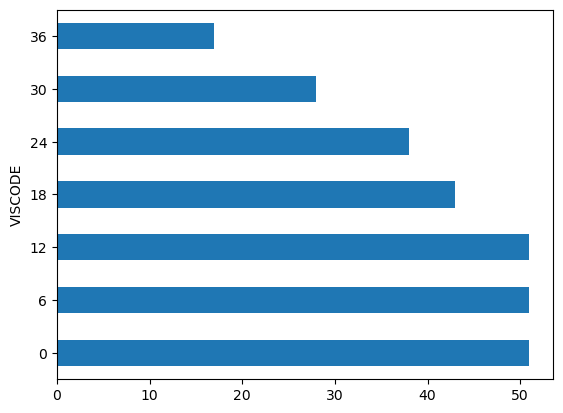

In [58]:
print(df["VISCODE"].value_counts().sort_index().to_frame())
df['VISCODE'].value_counts().sort_index().plot.barh()

Los valores muestran una reducción progresiva en la cantidad de registros a medida que aumenta el tiempo de seguimiento — de 51 sujetos al inicio, a solo 17 en el mes 36. Esto sugiere pérdida de participantes, algo habitual en estudios clínicos prolongados, ya sea por retiro, fallecimiento o datos incompletos.

* Variables Cognitivas

In [59]:
# Variables cognitivas
info_cognitiva = df.groupby('sujeto_id').agg({
    'CDRSB': ['min', 'mean', 'max'],
    'MMSE': ['min', 'mean', 'max'],
    'ADAS13': ['min', 'mean', 'max'],
    'FAQ': ['min', 'mean', 'max'],
    'RAVLT_immediate':['min', 'mean', 'max'],
    'RAVLT_learning': ['min', 'mean', 'max'],
    'RAVLT_forgetting': ['min', 'mean', 'max'],
    'DIGITSCOR': ['min', 'mean', 'max'],
    'TRABSCOR': ['min', 'mean', 'max'],
}).reset_index()


C:\Users\Hp\AppData\Local\Temp\ipykernel_34204\2176027057.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


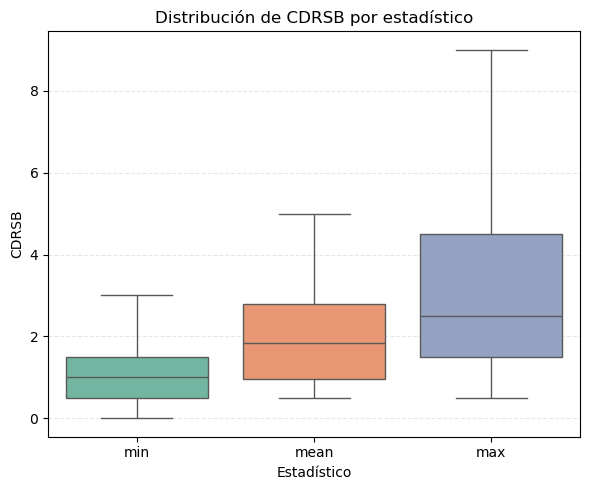

C:\Users\Hp\AppData\Local\Temp\ipykernel_34204\2176027057.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


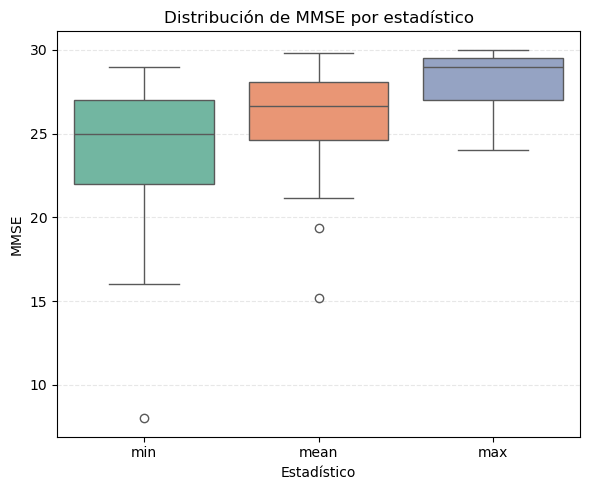

C:\Users\Hp\AppData\Local\Temp\ipykernel_34204\2176027057.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


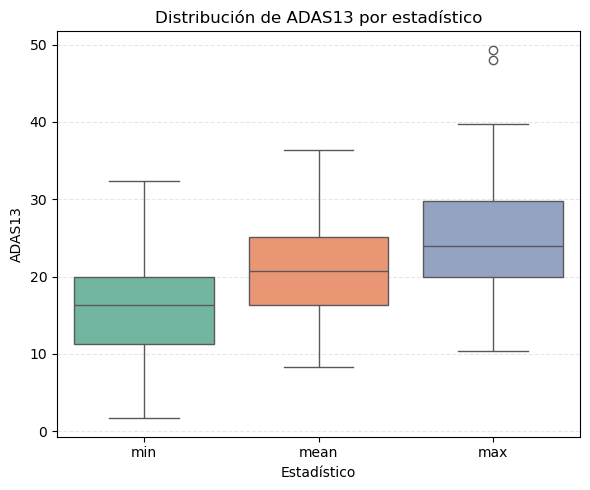

C:\Users\Hp\AppData\Local\Temp\ipykernel_34204\2176027057.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


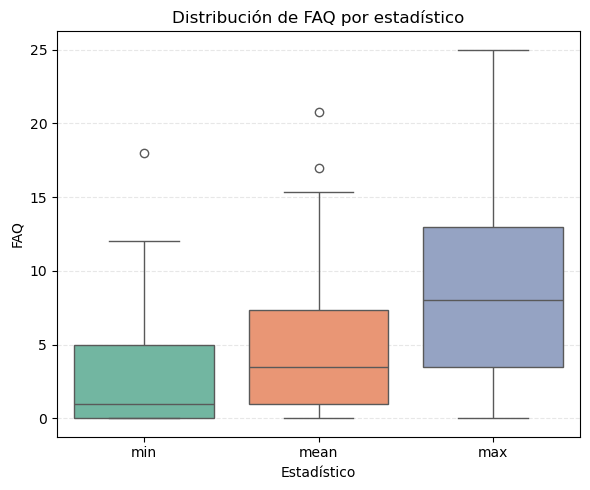

C:\Users\Hp\AppData\Local\Temp\ipykernel_34204\2176027057.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


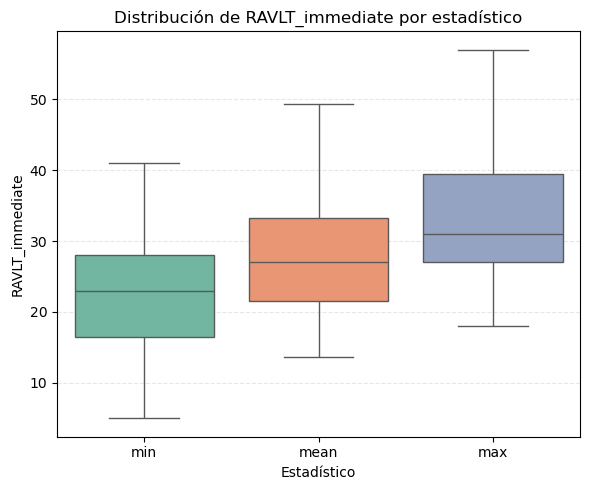

C:\Users\Hp\AppData\Local\Temp\ipykernel_34204\2176027057.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


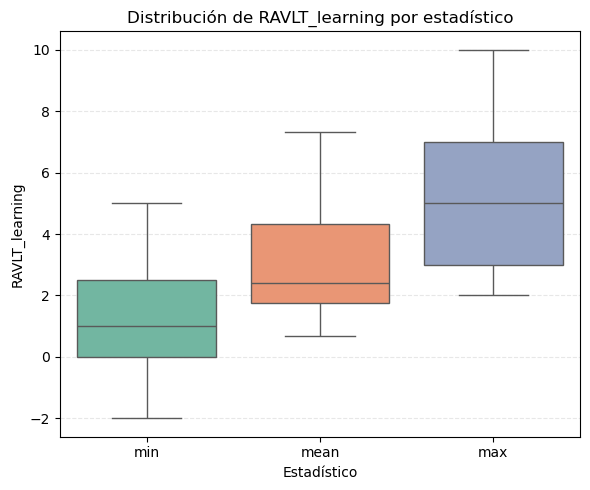

C:\Users\Hp\AppData\Local\Temp\ipykernel_34204\2176027057.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


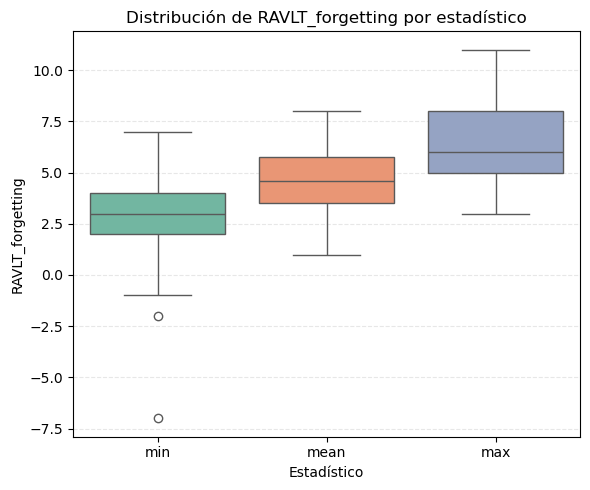

C:\Users\Hp\AppData\Local\Temp\ipykernel_34204\2176027057.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


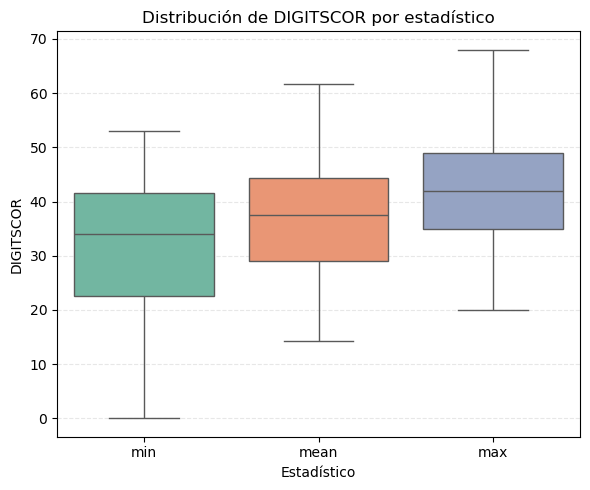

C:\Users\Hp\AppData\Local\Temp\ipykernel_34204\2176027057.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


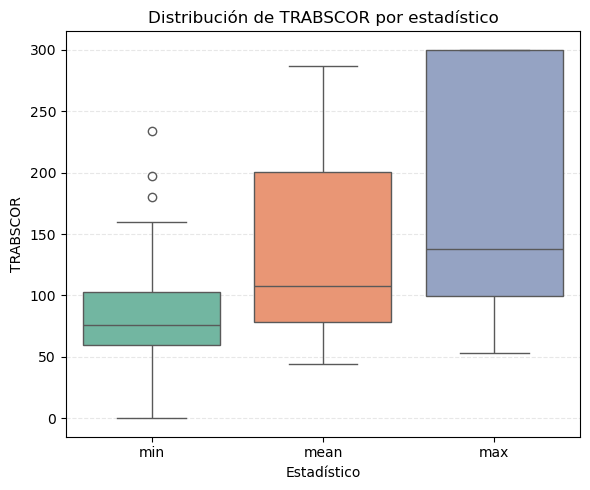

In [60]:
# Aplanar columnas
info_cognitiva.columns = ['sujeto_id'] + [f"{var}_{stat}" for var, stat in info_cognitiva.columns[1:]]

# Convertir a formato largo
info_long = pd.melt(
    info_cognitiva,
    id_vars="sujeto_id",
    var_name="variable_estadistica",
    value_name="valor"
)

# Separar nombre de variable y tipo de estadístico
info_long[["variable", "estadistica"]] = info_long["variable_estadistica"].str.rsplit("_", n=1, expand=True)

variables = info_long["variable"].unique()

for var in variables:
    plt.figure(figsize=(6, 5))
    sns.boxplot(
        data=info_long[info_long["variable"] == var],
        x="estadistica",
        y="valor",
        palette="Set2"
    )
    plt.title(f"Distribución de {var} por estadístico")
    plt.xlabel("Estadístico")
    plt.ylabel(var)
    plt.grid(axis="y", linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

In [61]:
# Agrupar por variable y estadístico
tabla_resumen = info_long.groupby(["variable", "estadistica"])["valor"].agg(["min", "mean", "max"]).round(2).reset_index()
# Ordenar por variable y tipo de estadístico
tabla_resumen = tabla_resumen.sort_values(["variable", "estadistica"])

# Mostrar
tabla_resumen

,variable,estadistica,min,mean,max
0,ADAS13,max,10.33,25.29,49.33
1,ADAS13,mean,8.33,20.74,36.40
2,ADAS13,min,1.67,16.27,32.33
3,CDRSB,max,0.50,2.98,9.00
4,CDRSB,mean,0.50,1.97,5.00
5,CDRSB,min,0.00,1.06,3.00
6,DIGITSCOR,max,20.00,42.22,68.00
7,DIGITSCOR,mean,14.20,37.28,61.67
8,DIGITSCOR,min,0.00,31.35,53.00
9,FAQ,max,0.00,8.53,25.00


Las variables cognitivas evaluadas reflejan distintos dominios del funcionamiento mental, desde la memoria hasta la función ejecutiva.

El **MMSE** presenta valores promedio entre 15 y 29 puntos, indicando una amplia variabilidad en el estado cognitivo general, desde deterioro leve hasta casi normalidad. De forma consistente, el **CDRSB** muestra medias entre 1 y 2 puntos, con máximos de hasta 9, lo que sugiere diferencias marcadas en la severidad clínica de la demencia.

El **ADAS13**, centrado en el deterioro asociado al Alzheimer, promedia entre 16 y 25 puntos, evidenciando un grado de afectación moderado en gran parte de los pacientes. En el ámbito funcional, el **FAQ** mantiene medias entre 2 y 5 puntos, reflejando una pérdida leve a moderada en las actividades diarias.

Las pruebas de memoria verbal (**RAVLT**) muestran un rendimiento variable: las puntuaciones inmediatas y de aprendizaje oscilan entre 23 y 33, mientras que el índice de olvido (RAVLT_forgetting) evidencia una retención disminuida en varios casos. Por su parte, la atención y la memoria de trabajo (**DIGITSCOR**) se mantienen relativamente conservadas, con medias alrededor de 37 puntos.

Finalmente, el **TRABSCOR**, indicador de la función ejecutiva, alcanza promedios cercanos a 135 segundos, reflejando una ralentización cognitiva en algunos sujetos.
En conjunto, los resultados confirman la heterogeneidad del perfil cognitivo en la muestra, coherente con diferentes etapas del deterioro cognitivo y la demencia.


* Variables sobre el volumen MRI

In [62]:
# Variables de de Volúmenes MRI
info_volumen = df.groupby('sujeto_id').agg({
    'Ventricles' : ['min', 'mean', 'max'],
    'Hippocampus': ['min', 'mean', 'max'],
    'WholeBrain': ['min', 'mean', 'max'], 
    'Entorhinal': ['min', 'mean', 'max'],
    'Fusiform': ['min', 'mean', 'max'],
    'MidTemp': ['min', 'mean', 'max'],
    'ICV': ['min', 'mean', 'max']
}).reset_index()

C:\Users\Hp\AppData\Local\Temp\ipykernel_34204\1002387156.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


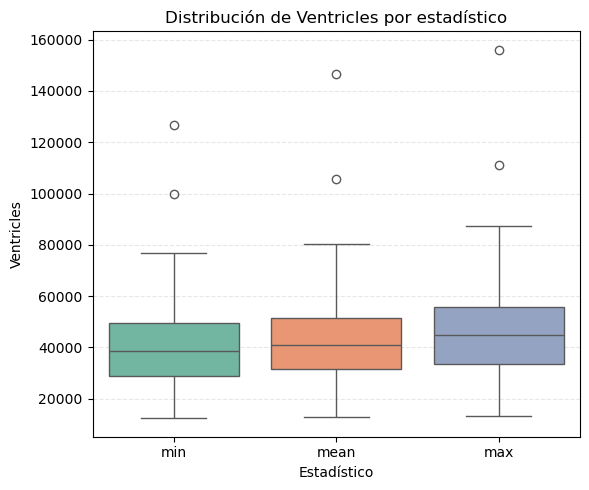

C:\Users\Hp\AppData\Local\Temp\ipykernel_34204\1002387156.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


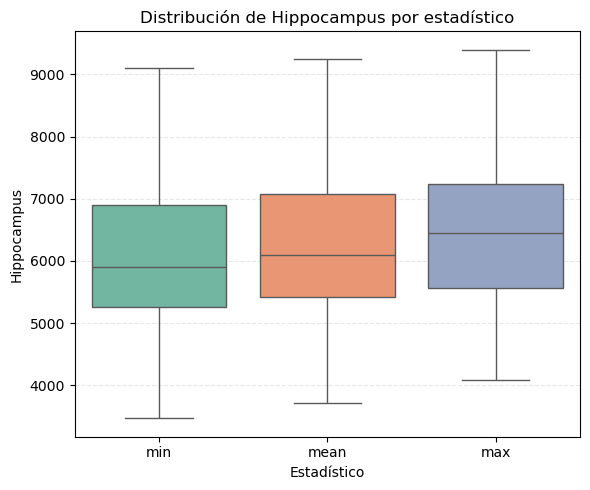

C:\Users\Hp\AppData\Local\Temp\ipykernel_34204\1002387156.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


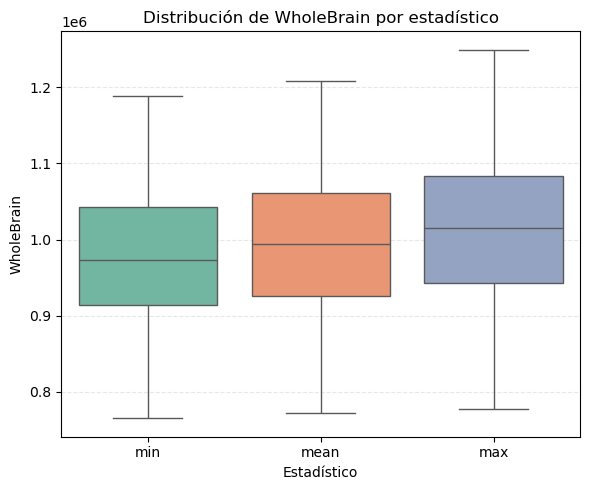

C:\Users\Hp\AppData\Local\Temp\ipykernel_34204\1002387156.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


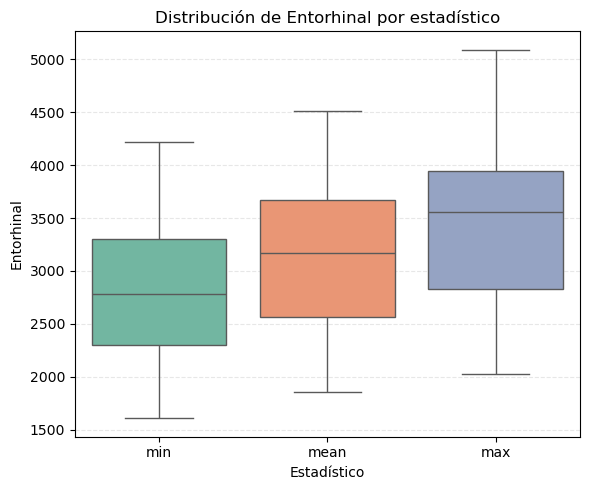

C:\Users\Hp\AppData\Local\Temp\ipykernel_34204\1002387156.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


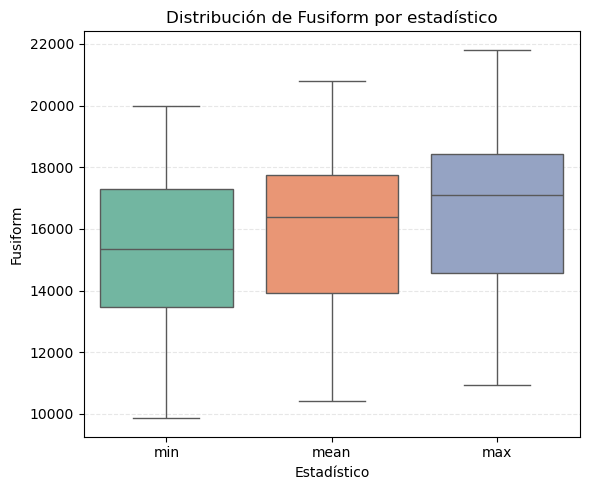

C:\Users\Hp\AppData\Local\Temp\ipykernel_34204\1002387156.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


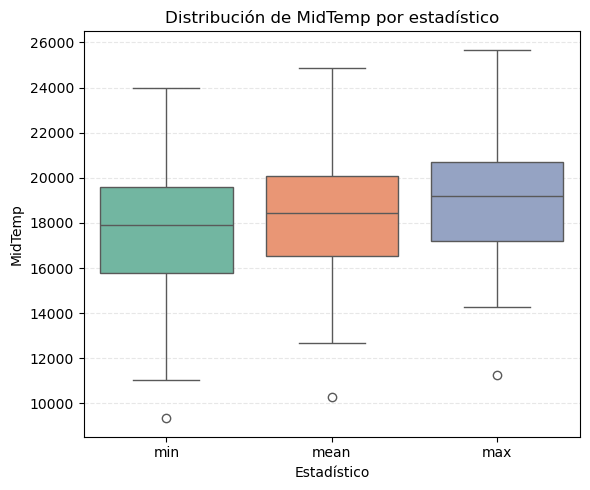

C:\Users\Hp\AppData\Local\Temp\ipykernel_34204\1002387156.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


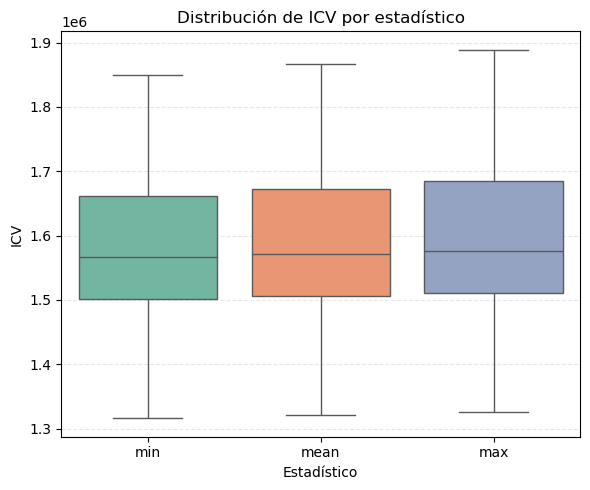

In [63]:
# Aplanar columnas
info_volumen.columns = ['sujeto_id'] + [f"{var}_{stat}" for var, stat in info_volumen.columns[1:]]

# Convertir a formato largo
info_long = pd.melt(
    info_volumen,
    id_vars="sujeto_id",
    var_name="variable_estadistica",
    value_name="valor"
)

# Separar nombre de variable y tipo de estadístico
info_long[["variable", "estadistica"]] = info_long["variable_estadistica"].str.rsplit("_", n=1, expand=True)

variables = info_long["variable"].unique()

for var in variables:
    plt.figure(figsize=(6, 5))
    sns.boxplot(
        data=info_long[info_long["variable"] == var],
        x="estadistica",
        y="valor",
        palette="Set2"
    )
    plt.title(f"Distribución de {var} por estadístico")
    plt.xlabel("Estadístico")
    plt.ylabel(var)
    plt.grid(axis="y", linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

In [64]:
# Agrupar por variable y estadístico
tabla_resumen = info_long.groupby(["variable", "estadistica"])["valor"].agg(["min", "mean", "max"]).round(2).reset_index()
# Ordenar por variable y tipo de estadístico
tabla_resumen = tabla_resumen.sort_values(["variable", "estadistica"])

# Mostrar
tabla_resumen

,variable,estadistica,min,mean,max
0,Entorhinal,max,2023.00,3481.71,5090.0
1,Entorhinal,mean,1853.00,3157.49,4511.2
2,Entorhinal,min,1608.00,2832.86,4215.0
3,Fusiform,max,10946.00,16742.86,21808.0
4,Fusiform,mean,10424.33,16061.54,20798.8
5,Fusiform,min,9860.00,15365.92,19972.0
6,Hippocampus,max,4087.00,6431.73,9396.0
7,Hippocampus,mean,3717.67,6205.67,9251.5
8,Hippocampus,min,3471.00,5997.59,9102.0
9,ICV,max,1325720.00,1595814.31,1888900.0


Las variables de volumen derivadas de imágenes de resonancia magnética permiten cuantificar la estructura anatómica del cerebro y detectar cambios asociados con la atrofia y el deterioro cognitivo.

En general, los **volúmenes medios** observados muestran una distribución coherente con las variaciones esperadas entre sujetos y posibles etapas de deterioro. El **volumen intracraneal total** (**ICV**) presenta valores promedio cercanos a **1.59 millones de mm³**, siendo una medida anatómica estable que se utiliza para normalizar otras variables de volumen.

El **volumen total cerebral** (**WholeBrain**) muestra valores promedio alrededor del **millón de mm³**, mientras que los **ventrículos** (**Ventricles**) presentan una alta variabilidad (media ≈ 47.000 mm³), lo cual es característico de la expansión ventricular asociada a procesos de atrofia cortical.

Regiones críticas vinculadas con la memoria, como el **hipocampo** (**Hippocampus**) y la **corteza entorrinal** (**Entorhinal**), presentan volúmenes medios de aproximadamente **6.200 mm³** y **3.100 mm³**, respectivamente. La reducción en estas áreas se considera uno de los primeros indicadores estructurales del Alzheimer.

Por otro lado, estructuras del lóbulo temporal, como el **giro fusiforme** (**Fusiform**) y el **lóbulo temporal medio** (**MidTemp**), presentan volúmenes intermedios (entre **15.000 y 18.000 mm³**), reflejando su participación en procesos de reconocimiento visual y auditivo.

En conjunto, los resultados muestran una tendencia esperada de atrofia progresiva, principalmente en regiones temporales y de memoria, mientras que **ICV** y **WholeBrain** actúan como referencias anatómicas estables para la comparación entre sujetos y sesiones.

* Diagnostico Inicial vrs Final

In [65]:
df_dx = df.sort_values(["sujeto_id", "VISCODE"]).groupby("sujeto_id").agg(
    dx_inicio=("DX", "first"),
    dx_final=("DX", "last")
).reset_index()
tabla_transicion = df_dx.groupby(["dx_inicio", "dx_final"]).size().unstack(fill_value=0)
tabla_transicion

dx_final,Dementia,MCI
dx_inicio,,
MCI,22,29


El diagnóstico inicial muestra que todos los participantes comenzaron el estudio con **deterioro cognitivo leve (MCI)**. Sin embargo, al finalizar el seguimiento, **22 de ellos progresaron a demencia**, mientras que **29 se mantuvieron en la misma condición**. Esto refleja una tendencia esperada en la evolución clínica del MCI, donde una proporción significativa de pacientes presenta un empeoramiento cognitivo a lo largo del tiempo, mientras que otros permanecen estables.


## **5. Análisis Bivariado**

* dx_final x Edad

In [66]:
df_final = df.sort_values(["sujeto_id", "VISCODE"]).groupby("sujeto_id").agg(
    edad_final=("AGE", "last"),
    dx_final=("DX", "last")
).reset_index()
tabla_edad_dx = df_final.groupby("dx_final")["edad_final"].describe().round(1)
tabla_edad_dx


,count,mean,std,min,25%,50%,75%,max
dx_final,,,,,,,,
Dementia,22.0,74.2,6.8,60.3,70.4,74.7,79.2,88.3
MCI,29.0,74.8,7.1,60.7,70.3,75.2,79.4,86.1


Los pacientes con deterioro cognitivo leve (MCI) presentan una edad promedio de 74.8 años (DE = 7.1), con un rango entre 60.7 y 86.1 años. Por su parte, los pacientes diagnosticados con demencia muestran una edad promedio ligeramente menor, de 74.2 años (DE = 6.8), con un rango entre 60.3 y 88.3 años.

Ambos grupos presentan distribuciones similares en sus valores mínimos y máximos, concentrando el 50 % central de los casos (rango intercuartílico) entre los 70 y 80 años.

* Valores COGNI x VISCODE

In [67]:
df.groupby(["VISCODE"]).mean(numeric_only=True)[[ 'CDRSB', 'MMSE', 'ADAS13', 'FAQ', 'RAVLT_immediate', 'RAVLT_learning',
       'RAVLT_forgetting', 'DIGITSCOR', 'TRABSCOR']]


,CDRSB,MMSE,ADAS13,FAQ,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,DIGITSCOR,TRABSCOR
VISCODE,,,,,,,,,
0,1.235294,27.372549,19.078627,3.500000,29.862745,3.745098,4.960784,37.725490,120.220000
6,1.627451,26.411765,19.467400,4.352941,28.137255,3.254902,4.529412,38.882353,118.755102
12,1.941176,26.333333,20.157451,5.360000,28.627451,3.235294,4.490196,36.901961,135.843137
18,2.348837,25.581395,22.200930,6.116279,27.714286,2.714286,4.476190,37.069767,137.465116
24,2.837838,24.815789,23.491842,7.837838,26.447368,2.552632,4.736842,35.289474,160.684211
30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,2.812500,25.647059,21.372353,7.235294,27.529412,3.352941,4.687500,38.562500,151.176471


El análisis temporal de los puntajes cognitivos muestra una tendencia progresiva hacia el deterioro conforme avanza el seguimiento clínico (de 0 a 36 meses), consistente con la evolución esperada en cohortes con riesgo o diagnóstico de Alzheimer.

En la **escala CDRSB (Clinical Dementia Rating Sum of Boxes)**, que mide la severidad de la demencia, los valores medios aumentan de **1.23 en el inicio** a **2.84 al mes 24**, indicando una mayor afectación funcional y cognitiva.
En contraste, el **MMSE (Mini-Mental State Examination)**, que evalúa el estado cognitivo global, muestra un descenso gradual de **27.3 a 24.8 puntos**, reflejando una pérdida de funciones cognitivas generales.

El **ADAS13**, un índice sensible al deterioro en Alzheimer, pasa de **19.0 a 23.5 puntos** en el mismo periodo, reforzando esta tendencia al empeoramiento. De manera paralela, el **FAQ**, que evalúa la autonomía en actividades diarias, se incrementa de **3.5 a 7.8 puntos**, lo cual indica una disminución de la funcionalidad cotidiana.

En cuanto a las pruebas de memoria verbal (**RAVLT_immediate**, **RAVLT_learning** y **RAVLT_forgetting**), se observa un descenso leve en el rendimiento de aprendizaje y recuerdo con el tiempo, mientras que las medidas de **atención y funciones ejecutivas** (**DIGITSCOR** y **TRABSCOR**) presentan fluctuaciones más moderadas, aunque también con una ligera tendencia a la disminución del rendimiento o incremento del tiempo de ejecución.

En conjunto, estos resultados confirman un proceso de deterioro cognitivo progresivo, particularmente evidente en las medidas globales (CDRSB, MMSE, ADAS13) y funcionales (FAQ), coherente con la naturaleza degenerativa de la enfermedad de Alzheimer y su impacto acumulativo a lo largo de los años de seguimiento.


* Valores VOLUMEN x VISCODE

In [68]:
df.groupby(["VISCODE"]).mean(numeric_only=True)[[ 'Ventricles',
       'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp',
       'ICV']]

,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV
VISCODE,,,,,,,
0,42340.960784,6410.680851,1.004484e+06,3310.191489,16595.851064,18974.000000,1.582249e+06
6,43703.612245,6197.930233,9.968302e+05,3152.511628,16317.046512,18627.395349,1.585129e+06
12,45051.313725,6266.659091,9.957942e+05,3211.750000,16089.818182,18337.409091,1.585502e+06
18,48546.780488,6185.184211,9.920210e+05,3090.815789,16028.815789,17961.078947,1.587287e+06
24,49118.617647,5985.392857,9.839078e+05,3093.571429,15676.285714,18249.607143,1.592065e+06
30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,43194.400000,6010.833333,9.965634e+05,3006.333333,15955.166667,18281.166667,1.589993e+06


Los valores promedio de los volúmenes cerebrales muestran una evolución coherente con los procesos de deterioro cognitivo progresivo. A lo largo de las distintas visitas (**VISCODE**), se observa un incremento paulatino en el volumen de los **ventrículos cerebrales (Ventricles)**, pasando de aproximadamente 44,600 mm³ al inicio a más de 49,000 mm³ en el mes 24. Este aumento refleja la expansión ventricular asociada a la pérdida de tejido cerebral.

En contraste, el volumen del **hipocampo (Hippocampus)** presenta una tendencia descendente, disminuyendo desde unos 6,426 mm³ hasta cerca de 5,985 mm³ en el mismo periodo. Esta reducción es consistente con la atrofia hipocampal que caracteriza a los trastornos neurodegenerativos como el Alzheimer. Una trayectoria similar se observa en el **entorhinal (Entorhinal)**, región crucial para la memoria y la navegación espacial, que pasa de valores medios de 3,312 a cerca de 3,093 mm³.

El volumen del **cerebro completo (WholeBrain)** también disminuye progresivamente, desde aproximadamente 1,004,679 mm³ hasta 983,907 mm³ al mes 24, mientras que estructuras corticales específicas como el **fusiforme (Fusiform)** y el **temporal medio (MidTemp)** mantienen una reducción más leve pero constante. En particular, el **Fusiform** disminuye de 16,595 a 15,676 mm³, y el **MidTemp** de 18,974 a 18,249 mm³, lo que sugiere pérdida de masa en áreas relacionadas con el procesamiento visual y la memoria semántica.

Por su parte, el **volumen intracraneal total (ICV)** se mantiene estable a lo largo del tiempo, rondando los 1.58 millones de mm³, como es esperable al ser una medida estructural fija que no varía con la enfermedad sino que sirve de referencia para normalizar otros volúmenes.

En conjunto, estas tendencias reflejan un patrón de **atrofia cerebral progresiva**, con expansión ventricular y pérdida de volumen en estructuras corticales y subcorticales clave, consistente con la progresión típica del deterioro cognitivo y la enfermedad de Alzheimer.



## **6. Evolución del Diagnostico por Visita**

In [69]:
tabla_dx = df.pivot_table(
    index="sujeto_id",
    columns="VISCODE",
    values="DX",
    aggfunc="first"  # Asume que hay una sola entrada por sujeto-visita
).fillna("-") 
tabla_dx

VISCODE,0,6,12,18,24,36
sujeto_id,,,,,,
007_S_0101,MCI,MCI,MCI,MCI,Dementia,Dementia
007_S_0128,MCI,MCI,MCI,Dementia,Dementia,-
007_S_0249,MCI,MCI,Dementia,Dementia,Dementia,Dementia
013_S_0240,MCI,MCI,MCI,Dementia,-,-
014_S_0169,MCI,MCI,MCI,MCI,MCI,MCI
018_S_0057,MCI,MCI,MCI,Dementia,Dementia,-
018_S_0080,MCI,MCI,MCI,-,-,-
018_S_0087,MCI,MCI,MCI,MCI,-,-
018_S_0142,MCI,MCI,MCI,MCI,MCI,-


La tabla muestra la progresión longitudinal del diagnóstico clínico (**DX**) en cada participante (**sujeto_id**) a lo largo de las distintas visitas (**VISCODE**), que corresponden a intervalos de seguimiento de 0, 6, 12, 18, 24 y 36 meses.

En la mayoría de los casos, los sujetos inician el estudio con un diagnóstico de **deterioro cognitivo leve (MCI)**, que representa una etapa intermedia entre el envejecimiento cognitivo normal y la demencia. Sin embargo, conforme avanzan las visitas, se observa un número considerable de transiciones hacia el diagnóstico de **demencia (Dementia)**, lo que indica un deterioro progresivo en el estado cognitivo de varios participantes.

Este patrón es evidente en múltiples sujetos (por ejemplo, *007_S_0101*, *123_S_0108*), quien presenta un cambio de MCI a demencia a partir de las visitas correspondientes a los 18 o 24 meses. Dichas transiciones son indicativas del curso clínico esperado en poblaciones con riesgo de Alzheimer, donde la progresión suele manifestarse gradualmente en un periodo de dos a tres años.

No obstante, también se identifican participantes que **mantienen un diagnóstico estable de MCI** durante todo el seguimiento (como *014_S_0169*, *027_S_0116* o *035_S_0033*), lo que sugiere una evolución más lenta o incluso una posible estabilización del deterioro cognitivo.

Asimismo, se observan **ausencias de registro (“–”)** en algunas visitas, lo que puede deberse a pérdidas de seguimiento, datos faltantes o retiro de los sujetos del estudio, un aspecto común en estudios longitudinales de larga duración.

En conjunto, los datos reflejan la heterogeneidad en la evolución clínica de los pacientes con deterioro cognitivo leve: mientras algunos permanecen estables, otros progresan hacia demencia en distintos puntos del seguimiento.
